<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/3.%20Data%20Preparation/Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

# Other
from tqdm import tqdm
import time

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

In [12]:
# Create dataset
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv' -O data.csv

# Load the downloaded CSV files into pandas DataFrames
data = pd.read_csv('data.csv', delimiter=';')

X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']               # Target variable
data.shape

--2024-05-15 10:10:18--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188851 (184K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 184.42K  --.-KB/s    in 0.02s   

2024-05-15 10:10:18 (7.48 MB/s) - ‘data.csv’ saved [188851/188851]



(782, 69)

In [13]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity', 'Diagnosis_Presumptive', 'US_Number', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61',
                  'Unnamed: 62', 'Unnamed: 63' ,'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68'], axis=1)
data.shape

(782, 54)

In [14]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

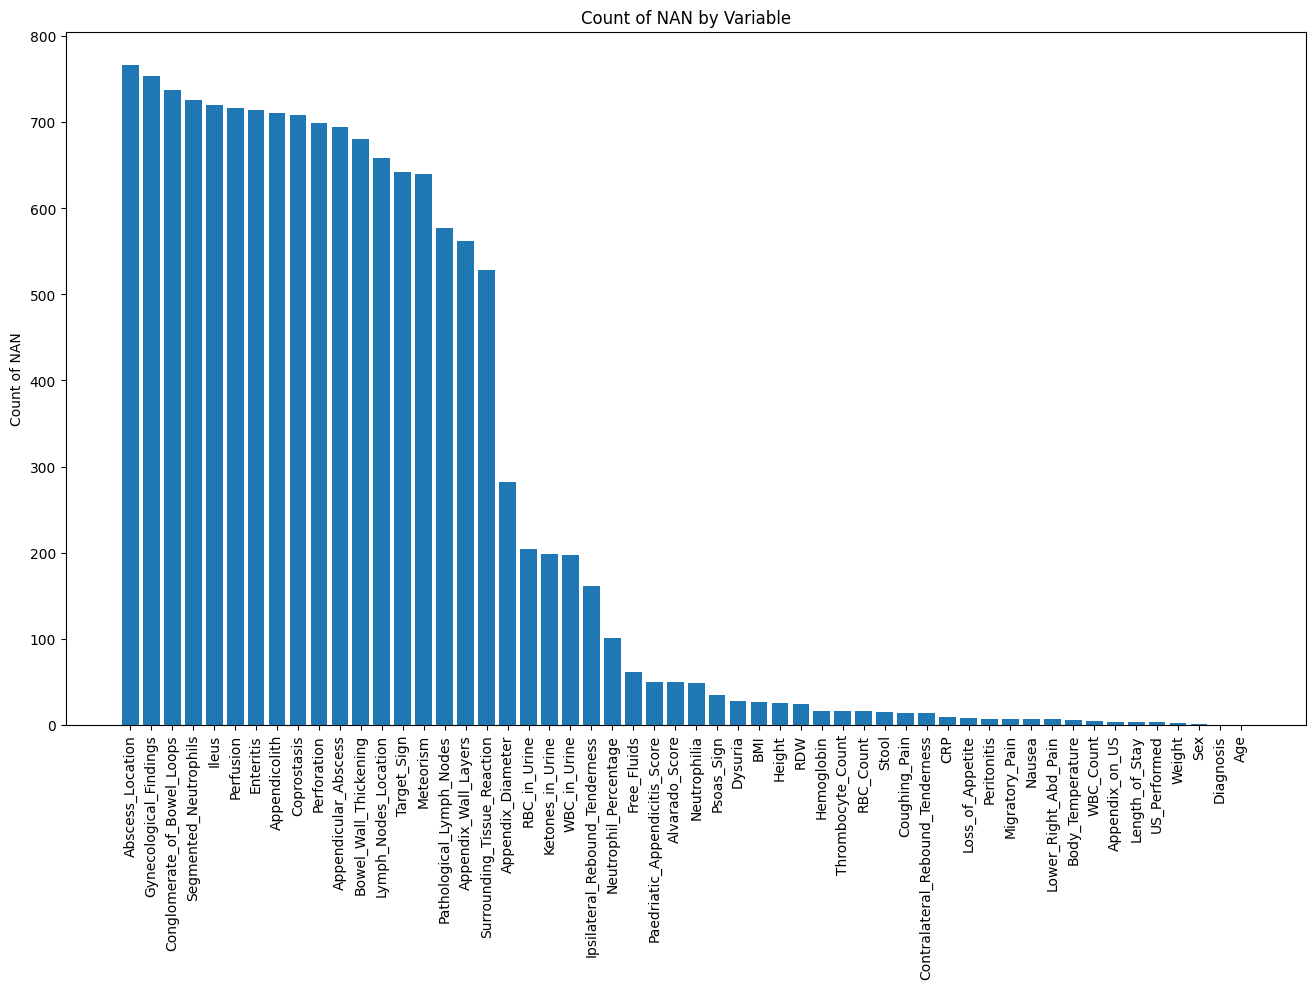

In [15]:
# visualizing count of NAN values
nan_counts = data.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

## Converting Variables to numeric & basic NAN imputation

In [16]:
def convert_variables(df):
    # Demographic Variables
    df["Sex"] = df["Sex"].replace(['male', 'female', 'no'], [1, 0, np.nan])

    # Clinical Variables
    df["Peritonitis"] = df["Peritonitis"].replace({"no": 0, "local": 1, "generalized": 1})
    df["Migratory_Pain"] = df["Migratory_Pain"].replace({'yes': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})
    df["Contralateral_Rebound_Tenderness"] = df["Contralateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Coughing_Pain"] = df["Coughing_Pain"].replace({'yes': 1, 'no': 0})
    df["Psoas_Sign"] = df["Psoas_Sign"].replace({'yes': 1, 'no': 0})
    df["Nausea"] = df["Nausea"].replace({'yes': 1, 'no': 0})
    df["Loss_of_Appetite"] = df["Loss_of_Appetite"].replace({'yes': 1, 'no': 0})
    df["Dysuria"] = df["Dysuria"].replace({'yes': 1, 'no': 0})
    df["Ipsilateral_Rebound_Tenderness"] = df["Ipsilateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Stool"] = df["Stool"].replace({'diarrhea': 1, 'normal': 0, 'constipation': 1, 'constipation, diarrhea': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"] = df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})

    # Laboratory Variables
    df["Ketones_in_Urine"] = df["Ketones_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["RBC_in_Urine"] = df["RBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["WBC_in_Urine"] = df["WBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["Neutrophilia"] = df["Neutrophilia"].replace({'yes': 1, 'no': 0})

    # Ultrasound Variables
    df["US_Performed"] = df["US_Performed"].replace({'yes': 1, 'no': 0})
    df["Appendix_on_US"] = df["Appendix_on_US"].replace({'yes': 1, 'no': 0})
    df["Free_Fluids"] = df["Free_Fluids"].replace({'yes': 1, 'no': 0})
    df["Appendix_Wall_Layers"] = df["Appendix_Wall_Layers"].replace({"intact": 0, "no": 0, "raised": 1, "partially raised": 1, "upset": 1})
    df['Target_Sign'] = df['Target_Sign'].replace({'yes': 1, 'no': 0})
    df["Perfusion"] = df["Perfusion"].replace({"no": 0, "present": 1, "hypoperfused": 0, "hyperperfused": 1})
    df["Perforation"] = df["Perforation"].replace({"no": 0, "suspected": 1, "not excluded": np.nan, "yes": 1})
    df["Surrounding_Tissue_Reaction"] = df["Surrounding_Tissue_Reaction"].replace({'yes': 1, 'no': 0})
    df["Pathological_Lymph_Nodes"] = df["Pathological_Lymph_Nodes"].replace({'yes': 1, 'no': 0})
    df["Bowel_Wall_Thickening"] = df["Bowel_Wall_Thickening"].replace({'yes': 1, 'no': 0})
    df["Ileus"] = df["Ileus"].replace({'yes': 1, 'no': 0})
    df["Coprostasis"] = df["Coprostasis"].replace({'yes': 1, 'no': 0})
    df["Meteorism"] = df["Meteorism"].replace({'yes': 1, 'no': 0})
    df["Enteritis"] = df["Enteritis"].replace({'yes': 1, 'no': 0})
    df["Appendicular_Abscess"] = df["Appendicular_Abscess"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Conglomerate_of_Bowel_Loops"] = df["Conglomerate_of_Bowel_Loops"].replace({'yes': 1, 'no': 0})
    df["Appendicolith"] = df["Appendicolith"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Gynecological_Findings"] = df["Gynecological_Findings"].replace({'Ovarialzyste': 1,
                                                                        'Zyste Uterus': 1,
                                                                        'In beiden Ovarien Zysten darstellbar, links Ovar mit regelrechter Perfusion, rechts etwas vergrößert, keine eindeutige Perfusion nachweisbar. Retrovesikal freie Flüssigkeit mit Binnenecho': 1,
                                                                        'Ausschluss pathologischer Ovarialbefund': 1,
                                                                        'kleine Ovarzyste rechts': 1,
                                                                        'kein Anhalt für eine gynäkologische Ursache der Beschwerden': 0,
                                                                        'V. a. Ovarialtorsion': 1,
                                                                        'Ausschluss gyn. Ursache der Beschwerden': 0,
                                                                        'ja': 1,
                                                                        'keine': 0,
                                                                        'Ovarialzysten': 1,
                                                                        'Ovarialzyste re.': 1,
                                                                        'unauffällig': 0,
                                                                        'Ovarialzyste ': 1})

    # Diagnosis
    df["Diagnosis"] = df["Diagnosis"].replace({'appendicitis': 1, 'no appendicitis': 0})

    # Dropping Columns
    df.drop("Lymph_Nodes_Location", axis=1, inplace=True)
    df.drop("Abscess_Location", axis=1, inplace=True)

    return df

In [17]:
# For all ultrasound variables, NAN are replaced by 0
def impute_US(df):
    df['Appendix_Wall_Layers'] = df['Appendix_Wall_Layers'].replace({np.nan: 0})
    df['Target_Sign'] = df['Target_Sign'].replace({np.nan: 0})
    df['Perforation'] = df['Perforation'].replace({np.nan: 0})
    df['Appendicular_Abscess'] = df['Appendicular_Abscess'].replace({np.nan: 0})
    df['Conglomerate_of_Bowel_Loops'] = df['Conglomerate_of_Bowel_Loops'].replace({np.nan: 0})
    df['Enteritis'] = df['Enteritis'].replace({np.nan: 0})
    df['Appendix_on_US'] = df['Appendix_on_US'].replace({np.nan: 0})
    df['Pathological_Lymph_Nodes'] = df['Pathological_Lymph_Nodes'].replace({np.nan: 0})
    df['Ileus'] = df['Ileus'].replace({np.nan: 0})
    df['Coprostasis'] = df['Coprostasis'].replace({np.nan: 0})
    df['Meteorism'] = df['Meteorism'].replace({np.nan: 0})
    df['Gynecological_Findings'] = df['Gynecological_Findings'].replace({np.nan: 0})
    df['Surrounding_Tissue_Reaction'] = df['Surrounding_Tissue_Reaction'].replace({np.nan: 0})
    df['Free_Fluids'] = df['Free_Fluids'].replace({np.nan: 0})
    df['Bowel_Wall_Thickening'] = df['Bowel_Wall_Thickening'].replace({np.nan: 0})

    return df

In [18]:
data = convert_variables(data)
data = impute_US(data)
data.shape

(780, 52)

In [19]:
# Numeric conversions with coercion for invalid entries
for col in data.columns:
    try:
        # Attempt to convert each column to numeric after replacing commas
        data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '.'), errors='coerce')
    except ValueError as e:
        print(f"Error converting {col}: {str(e)}")

In [20]:
# Calculate BMI for NAN, when height and weight is given
missing_bmi = data['BMI'].isnull()
missing_height = data['Height'].isnull()
missing_weight = data['Weight'].isnull()

height_in_meters_squared = (data['Height'] / 100) ** 2
calculated_bmi = data['Weight'] / height_in_meters_squared * 10000
data.loc[missing_bmi, 'BMI'] = calculated_bmi[missing_bmi]

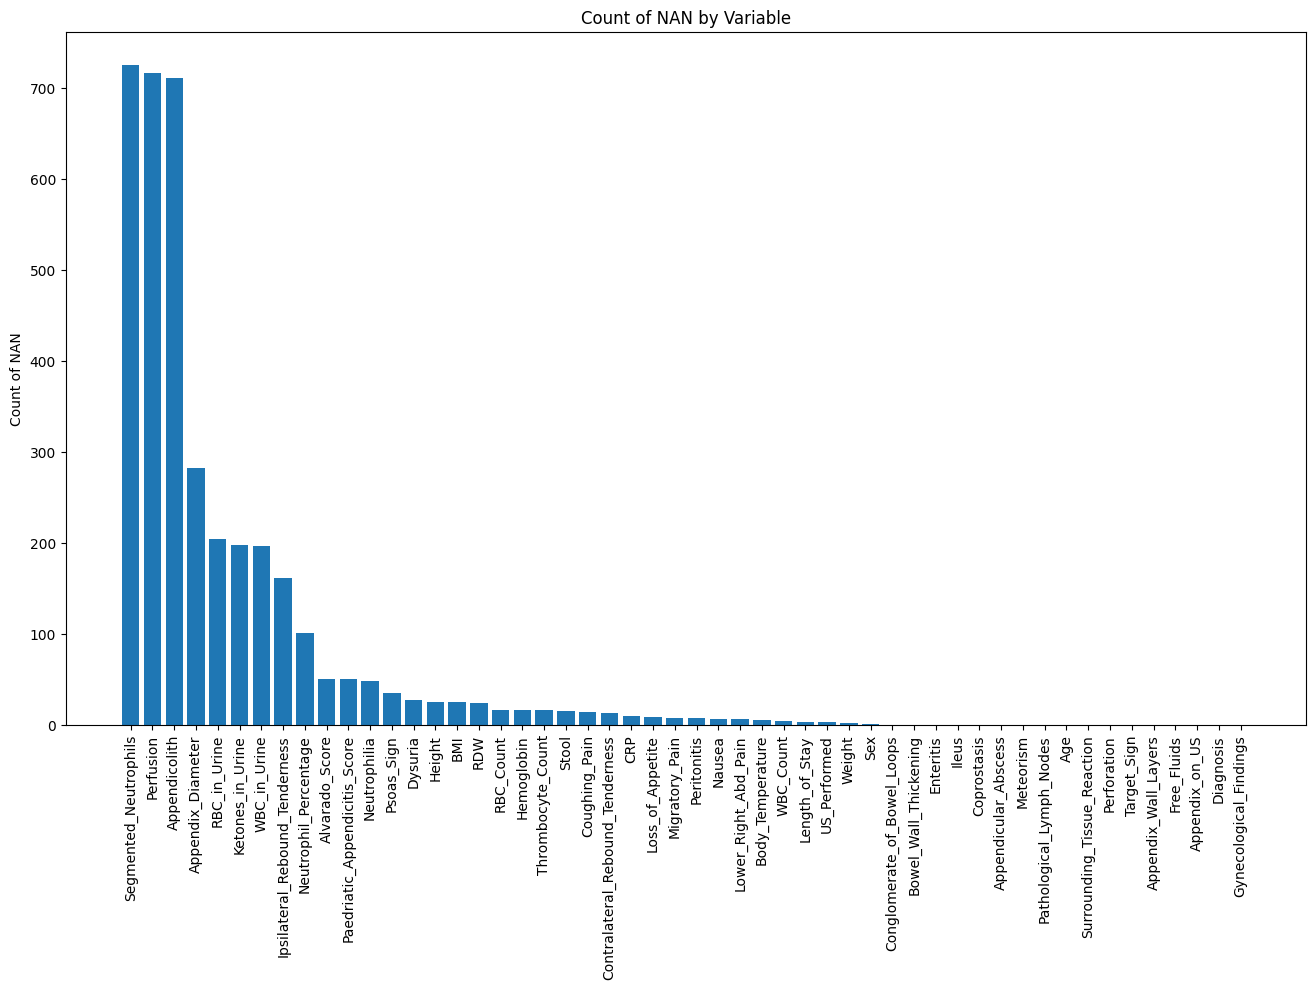

In [21]:
# visualizing count of NAN values
nan_counts = data.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

## Extracting a CSV file for Modelling

In [22]:
data.to_csv('modelling_data.csv', index=False)

# Colab file management to download the file to your local system
# from google.colab import files
# files.download('clean_data.csv')

## Filling NAN's with KNNImputer

In [23]:
# Creating a test dataset for the KNN imputer
df = data.drop(['Segmented_Neutrophils', 'Perfusion', 'Appendicolith'], axis=1)
df = df.dropna()
df.shape

(251, 49)

In [24]:
# Testing several values for k
epochs = 10
folds = 20
missing_values_proportion = 0.3
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 22, 25, 30, 40, 50, 60]
mse_values = {k: [] for k in k_values}
best_k = []
best_mse = []

for e in tqdm(range(epochs)):

    # Cross validation for calculating the mse for each fold
    for i in range(folds):
        missing_mask = np.random.rand(*df.shape) < missing_values_proportion
        df_with_nan = df.mask(missing_mask)

        for k in k_values:
            imputer = KNNImputer(n_neighbors=k)
            imputed_data = imputer.fit_transform(df_with_nan)

            mse = mean_squared_error(df, imputed_data)
            mse_values[k].append(mse)

    avg_mse_values = {k: np.mean(mse_values[k]) for k in k_values}

    min_k = min(k_values, key=lambda k: avg_mse_values[k])
    min_mse = avg_mse_values[min_k]

    best_k.append(min_k)
    best_mse.append(min_mse)

print("Average of best k:", np.mean(best_k), "(±", round(np.std(best_k), 2), ")" )
print("Average of MSE:", round(np.mean(best_mse), 2))

100%|██████████| 10/10 [05:15<00:00, 31.57s/it]

Average of best k: 23.4 (± 2.06 )
Average of MSE: 37.3


## Extracting a clean CSV file for EDA

In [25]:
imputation_knn = KNNImputer(n_neighbors=24)
clean_data = imputation_knn.fit_transform(data)
clean_data = pd.DataFrame(clean_data, columns=data.columns)
clean_data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Diagnosis,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Ketones_in_Urine,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Appendix_Wall_Layers,Target_Sign,Appendicolith,Perfusion,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,0.0,148.0,37.0,3.0,1.0,4.0,3.0,1.0,7.100000,0.0,1.0,1.0,0.0,0.0,1.0,37.0,7.7,68.2,63.216667,0.0,5.27,14.8,12.2,254.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.541667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.10,31.9,1.0,147.0,69.5,2.0,0.0,5.0,4.0,0.0,7.016667,1.0,1.0,1.0,0.0,0.0,1.0,36.9,8.1,64.8,63.466667,0.0,5.26,15.7,12.7,151.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.375000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.14,23.3,0.0,163.0,62.0,4.0,0.0,5.0,3.0,0.0,6.991667,0.0,1.0,1.0,0.0,0.0,0.0,36.6,13.2,74.8,61.591667,0.0,3.98,11.4,12.2,300.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.541667,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,16.37,20.6,0.0,165.0,56.0,3.0,0.0,7.0,6.0,0.0,6.950000,1.0,1.0,0.0,0.0,1.0,1.0,36.0,11.4,63.0,63.216667,0.0,4.64,13.6,13.2,258.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.416667,0.625000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.08,16.9,0.0,163.0,45.0,3.0,1.0,5.0,6.0,1.0,7.000000,0.0,1.0,1.0,1.0,1.0,1.0,36.9,8.1,44.0,61.383333,0.0,4.44,12.6,13.6,311.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.541667,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    float64
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Diagnosis                         780 non-null    float64
 7   Alvarado_Score                    780 non-null    float64
 8   Paedriatic_Appendicitis_Score     780 non-null    float64
 9   Appendix_on_US                    780 non-null    float64
 10  Appendix_Diameter                 780 non-null    float64
 11  Migratory_Pain                    780 non-null    float64
 12  Lower_Ri

In [28]:
# Extracting a csv without NAN values for EDA
clean_data.to_csv('clean_data.csv', index=False)

# Colab file management to download the file to your local system
from google.colab import files
files.download('clean_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>